## TDI Capstone Project 2023

* <b>Title:</b> Predicting Health Impairment from Social Determinants of Health.
* <b>Student:</b> Muhammad G. Saleh

# Table of Contents

- [Import Libraries](#Import-Libraries)
- [Functions](#Functions)
- [Load Data](#Load-Data)
- [DataFrame Cleanup and Save](#DataFrame-Cleanup-and-Save) 
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
    - [Health Impairment](#Health-Impairment)
    - [Health Status](#Health-Status)
    - [Age](#Age)
    - [Gender](#Gender)
    - [Ethnicity](#Ethnicity)
    - [Marital Status](#Marital-Status)
    - [Education](#Education) 
    - [Employment](#Employment) 
    - [Income based on Federal Poverty Levels (FPL)](#Income-based-on-Federal-Poverty-Levels-(FPL)) 
    - [Region of Residence](#Region-of-Residence)
    - [Moving](#Moving) 
    - [Safety in Neighborhoods](#Safety-in-Neighborhoods) 
- [Predictive Model: RandomForest Classifier](#Predictive-Model:-RandomForest-Classifier)
    - [Using all Features](#Using-all-Features) 
    - [Permutation Importance](#Permutation-Importance) 
    - [Using the Important Features and Oversampling](#Using-the-Important-Features-and-Oversampling)
- [Final Model](#Final-Model)
    - [User Input: New Data](#User-Input:-New-Data)
    - [Predict Using New Data](#Predict-Using-New-Data)
- [Conclusion](#Conclusion) 
    - [Recommendation](#Recommendation) 

## Import Libraries

In [1]:
# ! pip install dask-geopandas
# !pip install -U imbalanced-learn

In [2]:
import seaborn as sns
import warnings
import json
import ast
import geopandas #for geographical plots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import accuracy_score, confusion_matrix,\
classification_report, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.feature_selection import RFECV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from collections import Counter

## Functions

In [3]:
#Descriptive analysis
def describe_analy(arr_input, cont_var=1):
    # measures of central tendency
    mean = round(np.mean(arr_input),2)
    median = round(np.median(arr_input),2)
    # measures of dispersion
    min = round(np.amin(arr_input),2)
    max = round(np.amax(arr_input),2)
    range = round(np.ptp(arr_input),2)
    variance = round(np.var(arr_input),2)
    sd = round(np.std(arr_input),2)
    #display output
    print("\033[1m" + 'Descriptive analysis' + "\033[0m") #print in bold
    print("Minimum =", min)
    print("Maximum =", max)
    if cont_var:
        print("Mean =", mean)
        print("Median =", median)
        print("Range =", range)
        print("Variance =", variance)
        print("Standard Deviation =", sd)
    
    
# Stacked histoplots 
def sns_bar_graphs(df,x,y,weights=None,binwidth=5,stat='percent',multiple='fill',\
                   palette=None,color=None,edgecolor=None,shrink=0.8,discrete=None,ax=None):
    sns.histplot(
    df,
    x=x,
    # Use the value variable here to turn histogram counts into weighted values.
    weights=weights,
    binwidth=binwidth,
    stat=stat,
    hue=y,
    multiple=multiple,
    palette=palette,
    color=color,
    # Add white borders to the bars.
    edgecolor=edgecolor,
    # Shrink the bars a bit so they don't touch.
    shrink=shrink,
    discrete=discrete,
    ax=ax
)

[Return to contents](#Table-of-Contents)

## Load Data

In [4]:
org_df = pd.read_csv('37513-0001-Data.csv')
print(org_df.shape)
org_df.head()

(7588, 285)


,ID,VARUNIT,WEIGHT,Q1,Q2,Q3,Q5,Q5A,Q7,Q8,...,V_5_UNINSURED,RENTPROB_Y,UTILPROB_Y,UTILSUSP_Y,FOOD_INSEC,UNMETCARE_Y,BILLPROB_Y,MOVE_EVIC,ANY_HARDSHIP,MULT_HARDSHIP
0,1,15,0.4453,1,,0,2,,3,2,...,0,0,0,0,0,0,0,0,0,0
1,2,10,0.2257,1,,2,2,,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,11,1.2001,1,,0,1,,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,2,2.5802,5,2,0,0,,3,3,...,0,0,0,0,1,0,0,0,1,0
4,5,14,0.0828,1,,0,2,,4,1,...,0,0,1,0,0,0,1,0,1,1


[Return to contents](#Table-of-Contents)

## DataFrame Cleanup and Save 

### Fill in the blank cells with NaNs</b>

In [5]:
df1 = org_df.copy()
nan_value = float("NaN")
df1.replace(" ", nan_value, inplace=True)
df1.head()

,ID,VARUNIT,WEIGHT,Q1,Q2,Q3,Q5,Q5A,Q7,Q8,...,V_5_UNINSURED,RENTPROB_Y,UTILPROB_Y,UTILSUSP_Y,FOOD_INSEC,UNMETCARE_Y,BILLPROB_Y,MOVE_EVIC,ANY_HARDSHIP,MULT_HARDSHIP
0,1,15,0.4453,1,NaN,0,2,NaN,3,2,...,0,0,0,0,0,0,0,0,0,0
1,2,10,0.2257,1,NaN,2,2,NaN,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,11,1.2001,1,NaN,0,1,NaN,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,2,2.5802,5,2,0,0,NaN,3,3,...,0,0,0,0,1,0,0,0,1,0
4,5,14,0.0828,1,NaN,0,2,NaN,4,1,...,0,0,1,0,0,0,1,0,1,1


### Remove certain coloumns</b>
- <b>'_IMP', 'FAMSIZE':</b>  Imputed data 
- <b>'_FPL':</b> I will work with the salary ranges based on FPL
- <b>'INSURED', 'UNINSURED', 'RENTPROB_Y', 'UTILPROB_Y', 'UTILSUSP_Y', 'UNMETCARE_Y', 'BILLPROB_Y', 'MOVE_EVIC','ANY_HARDSHIP', 'MULT_HARDSHIP', 'NUM_OWNCHILD', 'ANY_CHILDHH', 'ANY_OWNCHILD_', 'PPMSACAT', '_MISS', 'MARRIED':</b>  Repeated or hold information from another another coloumn. Some of these coloumns are continuous variables, and removing them would reduce collinearity in the dataset. For instance, NUM_CHILD_HH (number of children in the household) holds the information of NUM_OWNCHILD (number of own children). Therefore, we will remove NUM_OWNCHILD
- <b>'VARUNIT':</b> Not used for our analysis
- <b>'WEIGHT':</b> Not used for our analysis
- <b>'ID':</b> ID can be replaced with the index in the dataframe
- <b>'Q3':</b> Replaced by NUM_CHILD_HH and ANYOWNCHILD
- <b>'Q67':</b> Masked by the source of the dataset

In [6]:
# get and remove coloumns that are redundant (repeated information or contains imputed data) 
unw_col_str1 = ['_IMP','_FPL','PPINCIMP','INSURED','UNINSURED' ,'_MISS','MARRIED','RENTPROB_Y','UTILPROB_Y',\
               'UTILSUSP_Y','UNMETCARE_Y','BILLPROB_Y','MOVE_EVIC','ANY_HARDSHIP','MULT_HARDSHIP',\
               'ANY_CHILDHH','ANY_OWNCHILD_','NUM_OWNCHILD','FAMSIZE','PPMSACAT','VARUNIT','WEIGHT', 'ID']
unw_columns = ['Q3','Q67']
for col_df in df1:
    for col_unw1 in unw_col_str1:
        if col_unw1 in col_df:
            unw_columns.append(col_df)
unw_columns
# len(unw_columns)
df1.drop(columns=unw_columns, inplace=True)
df1.head()

,Q1,Q2,Q5,Q5A,Q7,Q8,Q9,Q10,Q11,Q12_1,...,FPL50_100,FPL100_150,FPL150_200,FPL200_250,FPL250_300,FPL300_400,FPL400_500,FPL500_600,FPL_600PL,FOOD_INSEC
0,1,NaN,2,NaN,3,2,NaN,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,NaN,2,NaN,1,1,1,3,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1,NaN,1,NaN,1,1,1,1,NaN,2,...,0,0,0,0,0,1,0,0,0,0
3,5,2,0,NaN,3,3,NaN,1,1,2,...,1,0,0,0,0,0,0,0,0,1
4,1,NaN,2,NaN,4,1,3,2,NaN,2,...,0,1,0,0,0,0,0,0,0,0


### Remove Missing Values

In [7]:
df1.dropna(how='any', axis=1, inplace=True)
df1.head()

,Q1,Q5,Q7,Q8,Q10,Q12_1,Q12_2,Q12_3,Q16,Q18_1,...,PPAGE,PPEDUCAT,PPETHM,PPGENDER,PPHHHEAD,PPREG4,XACSNET,PARTNER,NUM_CHILD_HH,ANY_OWNCHILD
0,1,2,3,2,1,2,2,2,2,3,...,34,3,4,1,1,4,1,0,0,0
1,1,2,1,1,3,2,2,2,2,2,...,60,3,1,2,1,3,1,0,2,1
2,1,1,1,1,1,2,2,2,1,2,...,54,3,1,1,1,3,1,0,0,0
3,5,0,3,3,1,2,2,2,1,3,...,33,3,1,1,0,1,1,0,0,0
4,1,2,4,1,2,2,1,2,2,3,...,59,2,5,2,1,4,1,0,0,0


In [8]:
#Remove coloumns with negative values and reset index
for cols in df1.columns:
    indexNames = df1[ (df1[cols] < 0)].index
    df1.drop(indexNames, inplace=True)
df1.reset_index(drop = True,  inplace=True)
print(df1.shape)
df1.head(5)    

(5677, 89)


,Q1,Q5,Q7,Q8,Q10,Q12_1,Q12_2,Q12_3,Q16,Q18_1,...,PPAGE,PPEDUCAT,PPETHM,PPGENDER,PPHHHEAD,PPREG4,XACSNET,PARTNER,NUM_CHILD_HH,ANY_OWNCHILD
0,1,1,1,1,1,2,2,2,1,2,...,54,3,1,1,1,3,1,0,0,0
1,5,0,3,3,1,2,2,2,1,3,...,33,3,1,1,0,1,1,0,0,0
2,1,2,4,1,2,2,1,2,2,3,...,59,2,5,2,1,4,1,0,0,0
3,1,2,1,1,1,2,2,2,2,3,...,25,4,1,2,1,2,1,0,1,1
4,5,1,3,2,3,2,2,2,2,3,...,25,4,4,2,0,1,1,0,0,0


### Rename coloumns starting with the letter 'Q'</b>

In [9]:
df2 = df1.copy()
new_col_names  = ['MAR_STATUS', 'NUM_ADL_HH', 'RES_TYPE', 'RES_OWNSHIP', 'RES_COST', 'RES_PAY_RENT', 'RES_PAY_GAS',\
                  'RES_GAS_DEL','MOVING', 'MED_CARE_AVAIL', 'RECR_GRND_AVAIL', 'TRANSP_AVAIL', 'HLT_FOOD_AVAIL',\
                  'HSE_AFF_AVAIL','SCH_QUAL', 'SAFETY', 'HELP_NEIGH', 'HELP_FAM', 'HELP_FRND','HELP_COM_AGENCY',\
                  'FOOD_LASTED','FOOD_AFF', 'FOOD_ENO', 'FOOD_EATLESS', 'FOOD_NOMONEY', 'FOOD_FREE_GROC',\
                  'FOOD_FREE_MEAL','HLT_STATUS', 'HLT_IMPAIR', 'HLT_COND',\
                  'NERVOUS','HOPELESS', 'RESTLESS', 'SAD', 'ALOT_EFFORT', 'WORTHLESS', 'INS_COVERBBY', 'INS_FROM',\
                  'INS_MEDICARE', 'INS_ASSIS_PLAN', 'INS_MLTRY_CARE', 'INS_OTHERTYPE', 'INS_LENGTH', 'HLT_COST_AFF',\
                  'HLT_BILL_PAY', 'EMPLOYED', 'INC_SAL', 'INC_SELF_EMPLY', 'INC_INT_DIV_RENT', 'INC_SOCSEC',\
                  'INC_SUPPSEC', 'INC_WELF_PROG', 'INC_UNEMPLOYED_COMP', 'INC_WORK_COMP', 'INC_RETIREM',\
                  'INC_VETER_PAY', 'INC_CHILD_SUPP', 'INC_OTHER', 'INC_FPL_CATEG', 'INC_CHANGED', 'BENEFIT_FOOD',\
                  'BENEFIT_ENERGY', 'BENEFIT_TAX_CRD',\
                  'FEEL_CONTROL', 'FEEL_CONFIDENT', 'FEEL_YOURWAY', 'FEEL_OVERCOME', 'FNCL_PAYLOAN', 'FNCL_AUTOLOAN',\
                  'FNCL_SOLD_ITEMS', 'FNCL_CASH_CHECKS', 'FNCL_MISS_CRD_PAY', 'FNCL_MISS_LOAN_PAY', \
                  'FNCL_MONTH_EXPEND', 'FNCL_INC_DROP', 'FNCL_LARGE_EXPEND', 'FNCL_DEBT_AGENCY', 'FNCL_400_USD',\
                  'FNCL_2K_USD']


col_name_descr  = {'MAR': 'MARITAL', 'NUM': 'NUMBER', 'ADL': 'ADULT', 'RECR': 'RECREATION', 'GRND': 'GROUND',\
                   'TRANSP': 'TRANSPORT','MED': 'MEDICAL', 'AFF': 'AFFORD', 'FAM': 'FAMILY', 'FRND': 'FRIEND',\
                   'SCH': 'SCHOOL','OWNSHIP':'OWNERSHIP','HSE': 'HOUSE','ENO': 'ENOUGH', 'GROC': 'GROCERIES',\
                   'RES': 'RESIDENCE', 'DEL': 'DELIEVERY','TRANS': 'TRANSPORT', 'HLT': 'HEALTHY','NEIGH': 'NEIGHBOR',\
                   'HH': 'HOUSEHOLD', 'COM': 'COMMUNITY', 'INS': 'INSURANCE', 'ASSIS': 'ASSITANCE',\
                   'MLTRY': 'MILITARY','INC': 'INCOME', 'SAL': 'SALARY', 'EMPLY': 'EMPLOYMENT', 'INT': 'INTEREST',\
                   'DIV': 'DIVIDEND', 'SOCSEC': 'SOCIAL_SECURITY', 'SUPPSEC': 'SUPPLEMENTARY_SECURITY',\
                   'WELF': 'WELFARE','PROG': 'PROGRAM', 'COMP': 'COMPENSATION', 'RETIREM': 'RETIREMENT',\
                   'VETER': 'VETERANS', 'SUPP':'SUPPORT', 'FPL': 'FEDERAL_POVERTY_LEVEL', 'CATEG': 'CATEGORY',\
                   'CRD': 'CREDIT', 'FNCL': 'FINANCIAL', 'EXPEND': 'EXPENDITURE', 'USD': 'US_DOLLAR'}
for ii in range(0,len(new_col_names)):
    new_col_names[ii] = new_col_names[ii] + '_' +  df1.columns[ii]
new_col_names = [*new_col_names, *df1.columns[len(new_col_names):]]
df2.columns = new_col_names
#Save the new csv file and work with the new dataframe
df2.to_csv(r'family_mental_health_clean_4.csv', index=False, header=True)
print(df2.shape)
df2.head(5)    

(5677, 89)


,MAR_STATUS_Q1,NUM_ADL_HH_Q5,RES_TYPE_Q7,RES_OWNSHIP_Q8,RES_COST_Q10,RES_PAY_RENT_Q12_1,RES_PAY_GAS_Q12_2,RES_GAS_DEL_Q12_3,MOVING_Q16,MED_CARE_AVAIL_Q18_1,...,PPAGE,PPEDUCAT,PPETHM,PPGENDER,PPHHHEAD,PPREG4,XACSNET,PARTNER,NUM_CHILD_HH,ANY_OWNCHILD
0,1,1,1,1,1,2,2,2,1,2,...,54,3,1,1,1,3,1,0,0,0
1,5,0,3,3,1,2,2,2,1,3,...,33,3,1,1,0,1,1,0,0,0
2,1,2,4,1,2,2,1,2,2,3,...,59,2,5,2,1,4,1,0,0,0
3,1,2,1,1,1,2,2,2,2,3,...,25,4,1,2,1,2,1,0,1,1
4,5,1,3,2,3,2,2,2,2,3,...,25,4,4,2,0,1,1,0,0,0


[Return to contents](#Table-of-Contents)

## Exploratory Data Analysis (EDA)

Let's run some descriptive statistics and compare the distribution with the health impairment. This will inform us about the general characteristics of the participants in the dataset. 

### Health Impairment

The distribution of every class of Health Impairment:
None
2    4814
1     863
Name: HLT_IMPAIR_Q28, dtype: int64


Text(0.5, 0, 'Status')

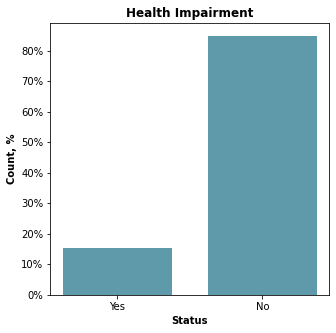

In [10]:
x_data = df2['HLT_IMPAIR_Q28'] 
fig, (ax1) = plt.subplots(1,1, figsize=(5, 5))
# #run descriptive analysis
# describe_analy(x_data,0)
#Counts for every class
# print('\n')
print(print("\033[1m" + 'The distribution of every class of Health Impairment:' + "\033[0m"))
print(x_data.value_counts())
# fig.subplots_adjust(hspace=0.125, wspace=0.125)
# 1st plot 
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               color= (sns.color_palette("viridis", 4))[1],
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks([1,2])
labels = ['Yes','No'] #Be careful with the labels
ax1.set_xticklabels(labels)
ax1.set_title('Health Impairment',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Status',fontweight="bold")

<b>Narration:</b> The cardinality of the Health Impairment feature is 2. The count of classes is not balanced, with the majority of the participants in the survey not having any health impairment. Our classifiers (e.g., RandomForest) will not predict with good accuracy the classes with lower proportions ('No -> 2'). We will <b>oversample</b> our data (e.g., SMOTE function) to allow better prediction of classes with lower proportion.

<b>Note: </b> Health impairment is a physical or mental condition, impairment, or disability that affects daily activities OR requires using special equipment or devices, such as a wheelchair, or communication device.

[Return to contents](#Table-of-Contents)

### Health Status

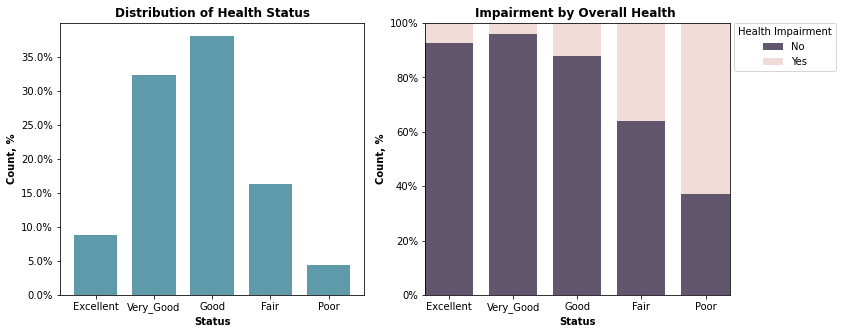

In [11]:
x_data = df2['HLT_STATUS_Q27']
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
# #run descriptive analysis
# describe_analy(x_data,0)
# 1st plot 
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               color= (sns.color_palette("viridis", 4))[1],
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels(['Excellent','Very_Good','Good','Fair','Poor'])
ax1.set_title('Distribution of Health Status',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Status',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.75,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks([1,2,3,4,5])
ax2.set_xticklabels(['Excellent','Very_Good','Good','Fair','Poor'])
ax2.set_title('Impairment by Overall Health ',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Status',fontweight="bold")
plt.margins(x=10,tight=False)
# plt.tight_layout()
plt.show()

<b>Narration:</b> The count of classes is not balanced with the dominating classes - 'Very Good -> 2' and 'Good -> 3' – each with more than 30% coverage. The graph on the right indicates that individuals with fair or worse heath probably suffer from a health impairment/condition.

[Return to contents](#Table-of-Contents)

### Age

Descriptive analysis
Minimum = 18
Maximum = 64
Mean = 44.33
Median = 45.0
Range = 46
Variance = 168.42
Standard Deviation = 12.98


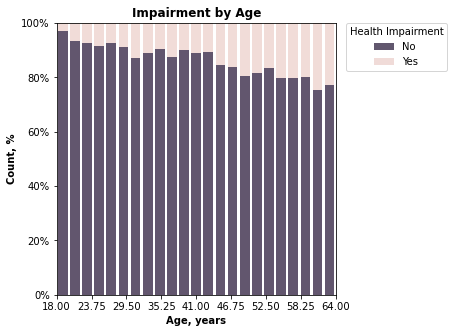

In [12]:
x_data = df2['PPAGE']
y_data = df2['HLT_IMPAIR_Q28']
fig, ax = plt.subplots(1,1, figsize=(5, 5))
#run descriptive analysis
describe_analy(x_data,1)
#genaral plots
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=2,
               stat='percent',
               multiple='fill',
               palette=None,
               edgecolor=None,
               shrink=0.8,
               ax=ax)
ax.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax.legend(labels,title="Health Impairment", bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
ax.set_xticks(np.linspace(18, 64, 9))
ax.set_title('Impairment by Age',fontweight="bold")
ax.set_ylabel('Count, %',fontweight="bold")
ax.set_xlabel('Age, years',fontweight="bold")
plt.show()

<b>Narration:</b> The participants have a wide age range, from 18 to 64 years, with the average age at approximately 44. A stacked bar plot shows that the proportion of individuals with a health impairment increases with age. This suggests that aging contributes to health impairment.

[Return to contents](#Table-of-Contents)

### Gender

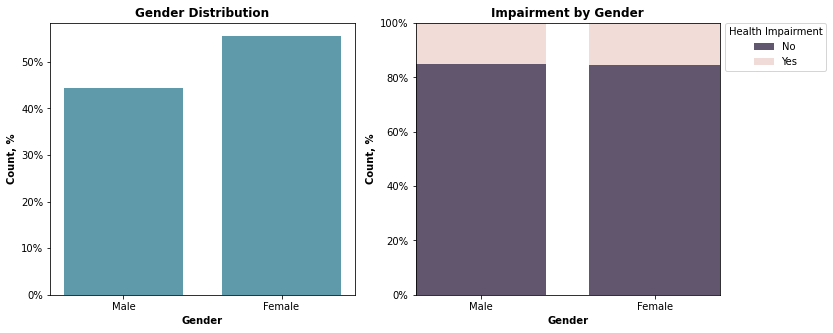

In [13]:
x_data = df2['PPGENDER'] #INC_SAL_Q50_1
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
#run descriptive analysis
# describe_analy(x_data,0)
# # fig.subplots_adjust(hspace=0.125, wspace=0.125)
# 1st plot 
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               color= (sns.color_palette("viridis", 4))[1],
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks([1,2])
ax1.set_xticklabels(['Male', 'Female'])
ax1.set_title('Gender Distribution',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Gender',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.75,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks([1,2])
ax2.set_xticklabels(['Male', 'Female'])
ax2.set_title('Impairment by Gender',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Gender',fontweight="bold")
plt.margins(x=10,tight=False)
# plt.tight_layout()
plt.show()

<b>Narration</b>: The number of female participants is modestly higher than men, but both genders have similar porportions of health conditions. 

[Return to contents](#Table-of-Contents)

### Ethnicity

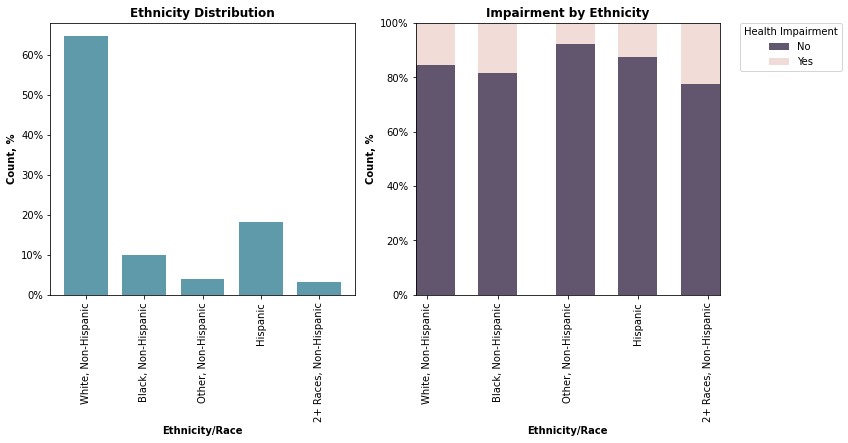

In [14]:
x_data = df2['PPETHM']
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
#run descriptive analysis
# describe_analy(x_data,0)
# # fig.subplots_adjust(hspace=0.125, wspace=0.125)
# 1st plot 
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               color= (sns.color_palette("viridis", 4))[1],
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks(np.linspace(1, 5, 5))
ax1.set_xticklabels(['White, Non-Hispanic','Black, Non-Hispanic','Other, Non-Hispanic','Hispanic','2+ Races, Non-Hispanic'],
                    rotation =90)
ax1.set_title('Ethnicity Distribution',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Ethnicity/Race',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=2.5,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks(np.linspace(1, 5, 5))
ax2.set_xticklabels(['White, Non-Hispanic','Black, Non-Hispanic','Other, Non-Hispanic','Hispanic','2+ Races, Non-Hispanic'])
ax2.set_title('Impairment by Ethnicity',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Ethnicity/Race',fontweight="bold")
plt.xticks(rotation=90)
plt.show()

<b>Narration:</b> The participants are either Non-Hispanic White, Black, mixed, other races, or Hispanic. The majority of participants are White and non-Hispanic. The proportion of individuals with no health impairment is ≥80% in all groups, suggesting that ethnicity might not be a good predictor of an impairment.

[Return to contents](#Table-of-Contents)

### Marital Status

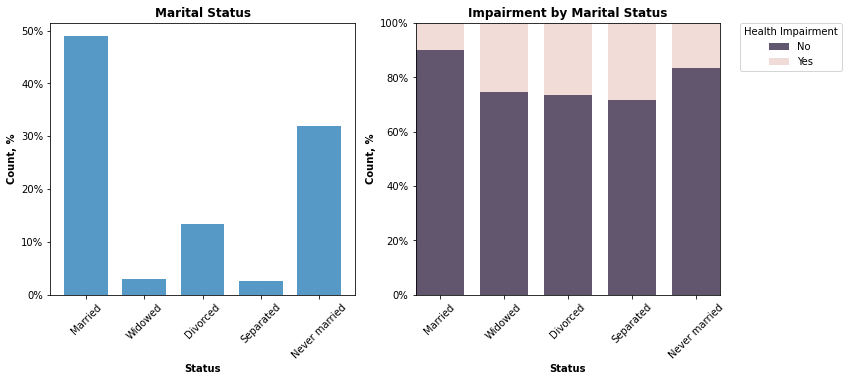

In [15]:
x_data = df2['MAR_STATUS_Q1']
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
# #run descriptive analysis
# describe_analy(x_data,0)
# # fig.subplots_adjust(hspace=0.125, wspace=0.125)
# 1st plot 
# sns.countplot(x=x_data, linewidth=2,ax=ax1)
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks(np.linspace(1, 5, 5))
ax1.set_xticklabels(['Married','Widowed','Divorced','Separated','Never married'],rotation =45)
ax1.set_title('Marital Status',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Status',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.75,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks(np.linspace(1, 5, 5))
ax2.set_xticklabels(['Married','Widowed','Divorced','Separated','Never married'],rotation =45)
ax2.set_title('Impairment by Marital Status',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Status',fontweight="bold")
plt.show()

<b>Narration:</b> Most participants are married (approx. 50%), whereas the rest are either never married (approx. 30%), widowed, divorced, or separated. Although the proportion of impairment varies between groups, the proportion of non-impaired individuals is higher in the married and never-married groups.

[Return to contents](#Table-of-Contents)

### Education

Descriptive analysis
Minimum = 1
Maximum = 4


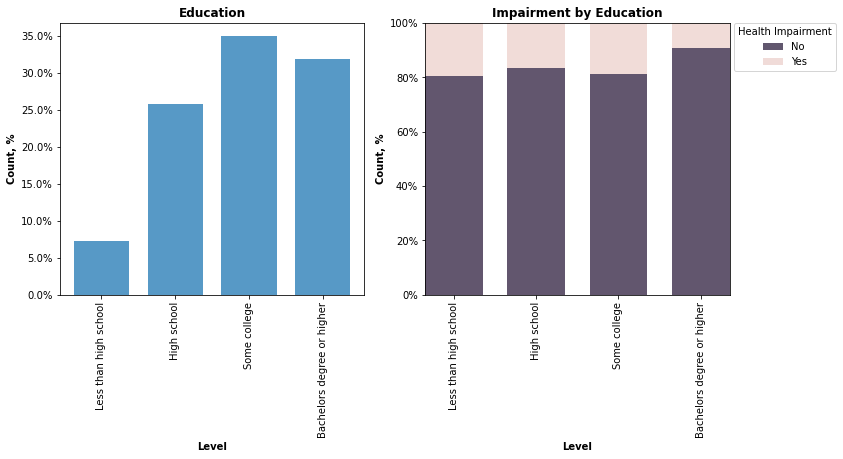

In [16]:
x_data = df2['PPEDUCAT']
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
#run descriptive analysis
describe_analy(x_data,0)
# # fig.subplots_adjust(hspace=0.125, wspace=0.125)
# 1st plot 
# sns.countplot(x=x_data, linewidth=2,ax=ax1)
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks(np.linspace(1, 4, 4))
ax1.set_xticklabels(['Less than high school','High school','Some college','Bachelors degree or higher'],rotation=90)
ax1.set_title('Education',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Level',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.7,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks(np.linspace(1, 4, 4))
ax2.set_xticklabels(['Less than high school','High school','Some college','Bachelors degree or higher'])
ax2.set_title('Impairment by Education',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Level',fontweight="bold")
plt.xticks(rotation=90)
plt.show()

<b>Narration:</b> Many individuals with a Bachelor's or a higher degree have no impairment. It could be due to better employment opportunities, procurement of better healthcare, and settlements (housing)

[Return to contents](#Table-of-Contents)

### Employment

Descriptive analysis
Minimum = 1
Maximum = 2


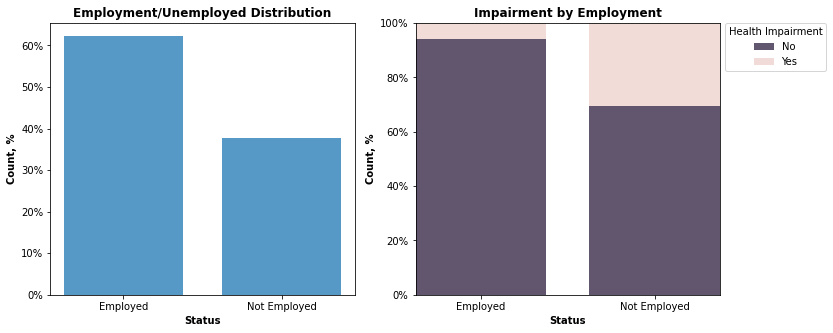

In [17]:
x_data = df2['EMPLOYED_Q37'] #INC_SAL_Q50_1
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
#run descriptive analysis
describe_analy(x_data,0)
# fig.subplots_adjust(hspace=0.125, wspace=0.125)
# 1st plot 
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks([1,2])
ax1.set_xticklabels(['Employed', 'Not Employed'])
ax1.set_title('Employment/Unemployed Distribution',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Status',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.75,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks([1,2])
ax2.set_xticklabels(['Employed', 'Not Employed'])
ax2.set_title('Impairment by Employment',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Status',fontweight="bold")
# plt.margins(x=10,tight=False)
# plt.tight_layout()
plt.show()

<b>Narration:</b> Although most participants are employed, a substantial number are unemployed (~40%). A large proportion of employed individuals have no impairment, perhaps due to the ability to purchase better health coverage.

[Return to contents](#Table-of-Contents)

### Income based on Federal Poverty Levels (FPL)

Descriptive analysis
Minimum = 1
Maximum = 10


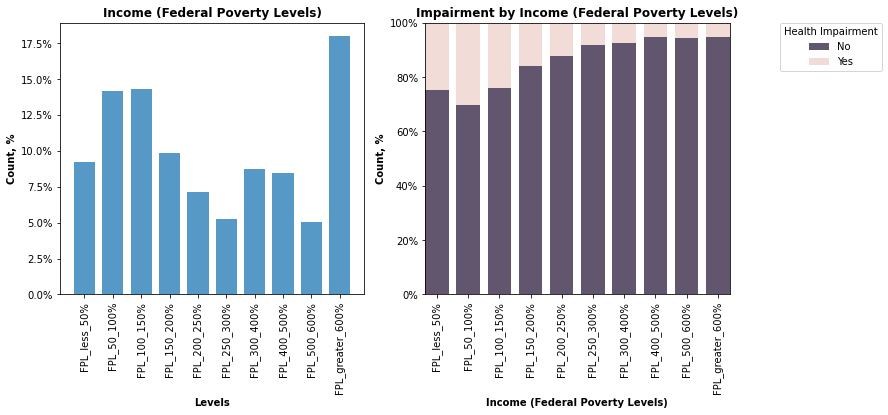

In [18]:
x_data = df2['INC_FPL_CATEG_Q51']
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
#run descriptive analysis
describe_analy(x_data,0)
# fig.subplots_adjust(hspace=0.125, wspace=0.125)
# 1st plot 
# sns.countplot(x=x_data, linewidth=2,ax=ax1)
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks(np.linspace(1, 10, 10))
ax1.set_xticklabels(['FPL_less_50%','FPL_50_100%','FPL_100_150%','FPL_150_200%','FPL_200_250%','FPL_250_300%',\
                     'FPL_300_400%','FPL_400_500%','FPL_500_600%','FPL_greater_600%'], rotation=90)
ax1.set_title('Income (Federal Poverty Levels)',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Levels',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.75,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.5, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks(np.linspace(1, 10, 10))
ax2.set_xticklabels(['FPL_less_50%','FPL_50_100%','FPL_100_150%','FPL_150_200%','FPL_200_250%','FPL_250_300%',\
                     'FPL_300_400%','FPL_400_500%','FPL_500_600%','FPL_greater_600%'], rotation=90)
ax2.set_title('Impairment by Income (Federal Poverty Levels)',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Income (Federal Poverty Levels)',fontweight="bold")
plt.show()

<b>Narration:</b> A large proportion of participants have incomes between 50% and 150% (~15% each) or greater than 600% of the federal poverty level (FPL). The health-condition comparison between different FPLs is quite striking. The proportion of non-impaired individuals increases as their income increases. A higher income allows individuals to purchase nutritious food, quality health coverage, and housing in a safe and quality (endowed) neighborhood. Income might be a good predictor of an impairment.

[Return to contents](#Table-of-Contents)

### Region of Residence

Read in the US map from the census website https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html. This will allow us to show the propotion of participants from different regiosnof the USA. The regions are <b>Northeast, Midwest, South, West</b>

In [19]:
regions_usa = geopandas.read_file('region_map/cb_2018_us_region_500k.shp')
#Build a temporary dataframe for regions
reg_df = pd.DataFrame(df2['PPREG4'].value_counts())
reg_df.insert(1,'NAME', ['South', 'West', 'Midwest', 'Northeast'],)
reg_df.index.name='ID'
reg_df = reg_df.sort_values(by=['ID'], ascending=True)
#Merge two dataframe 
merged_data= regions_usa.merge(reg_df, on=["NAME"])
#Create a proportion of participants from every region
merged_data['per_region'] = 100*(merged_data.PPREG4 / merged_data.PPREG4.sum())
#Add locations for annotations on the map
merged_data.insert(loc = 10, column= 'annot_loc',value = [[-73,40],[-95,40],[-115,40],[-90,32.5]])


    Residence by Region


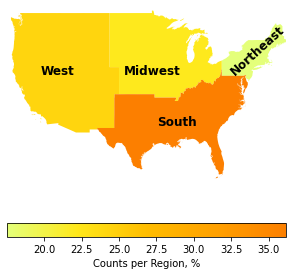

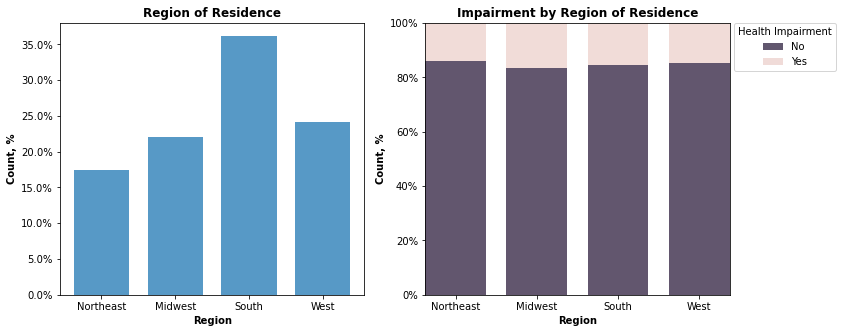

In [20]:
x_data = df2['PPREG4']
y_data = df2['HLT_IMPAIR_Q28']
# #run descriptive analysis
# describe_analy(x_data,0)
#1st plot
fig_reg, ax = plt.subplots(1,1, figsize=(5,5))
merged_data.plot(column='per_region',
                 ax=ax, 
                 legend=True, 
                 legend_kwds={'label': "Counts per Region, %",
                              'orientation': "horizontal"},
                 cmap='Wistia');

for idx, row in merged_data.iterrows():
    rot_ann = [42,0,0,0]
    plt.annotate(text=row['NAME'], 
                 horizontalalignment='center',
                 xy=row['annot_loc'],
                 color='black',
                 alpha = 1.,
                 font = {'weight':'bold', 'size':12},
                 rotation=rot_ann[idx])
    
ax.axis('off')
ax.set_title(print('\n', "\033[1m" + '   Residence by Region' + "\033[0m"))
plt.xlim([-125.5,-67])
plt.ylim([24,50])
# disabling xticks by Setting xticks to an empty list
# plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
# plt.yticks([]) 

#Two separate figures
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
# fig.subplots_adjust(hspace=0.125, wspace=0.125)
# 2nd plot
# sns.countplot(x=x_data, linewidth=2,ax=ax1)
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks(np.linspace(1, 4, 4))
ax1.set_xticklabels(['Northeast','Midwest','South','West'], rotation=0)
ax1.set_title('Region of Residence',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Region',fontweight="bold")

#3rd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.75,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks(np.linspace(1, 4, 4))
ax2.set_xticklabels(['Northeast','Midwest','South','West'], rotation=0)
ax2.set_title('Impairment by Region of Residence',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Region',fontweight="bold")
plt.show()

<b>Narration:</b> The cohort comprises participants from all regions of the mainland USA, with an equivalent proportion, except the Southern region, which has ~15% more participants. All four regions have a similar distribution of health impairment, and the proportion of individuals with a health condition is lower in all regions.

[Return to contents](#Table-of-Contents)

### Moving

Descriptive analysis
Minimum = 1
Maximum = 2


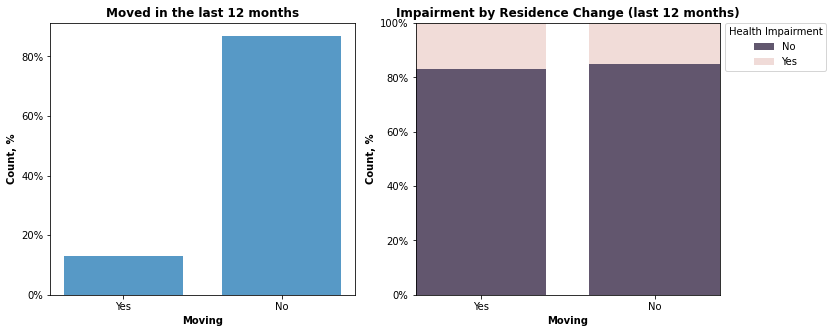

In [21]:
x_data = df2['MOVING_Q16']
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
# fig.subplots_adjust(hspace=0.125, wspace=0.125)
#run descriptive analysis
describe_analy(x_data,0)
# 1st plot 
# sns.countplot(x=x_data, linewidth=2,ax=ax1)
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks(np.linspace(1, 2, 2))
ax1.set_xticklabels(['Yes','No'], rotation=0)
ax1.set_title('Moved in the last 12 months',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Moving',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.75,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks(np.linspace(1, 2, 2))
ax2.set_xticklabels(['Yes','No'], rotation=0)
ax2.set_title('Impairment by Residence Change (last 12 months)',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Moving',fontweight="bold")
plt.show()

<b>Narration:</b> Most participants did not move in the last 12 months, suggesting stability in housing. Furthermore, the two groups have a similar distribution, indicating that moving might not be a predictor of an impairment.

[Return to contents](#Table-of-Contents)

#### Safety in Neighborhoods

Descriptive analysis
Minimum = 1
Maximum = 5


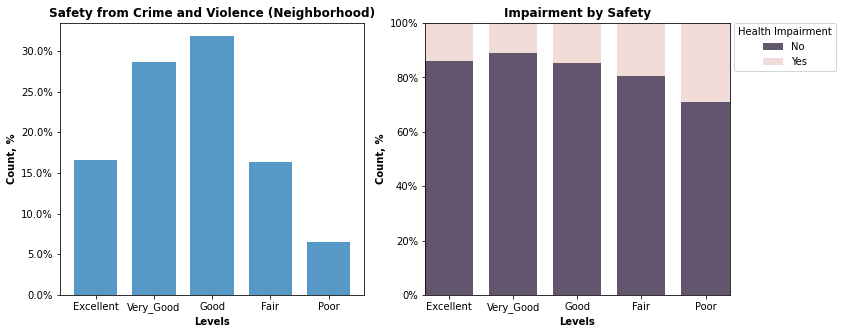

In [22]:
x_data = df2['SAFETY_Q18_7']
y_data = df2['HLT_IMPAIR_Q28']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
# fig.subplots_adjust(hspace=0.125, wspace=0.125)
#run descriptive analysis
describe_analy(x_data,0)
# 1st plot 
# sns.countplot(x=x_data, linewidth=2,ax=ax1)
sns_bar_graphs(df2,
               x_data,
               y = None,
               weights=None,
               binwidth=None,
               stat='percent',
               multiple="dodge",
               shrink=0.75,
               discrete=True,
               ax=ax1)
ax1.yaxis.set_major_formatter(PercentFormatter(100)) #change to 100%
ax1.set_xticks(np.linspace(1, 5, 5))
ax1.set_xticklabels(['Excellent','Very_Good','Good','Fair', 'Poor'], rotation=0)
ax1.set_title('Safety from Crime and Violence (Neighborhood)',fontweight="bold")
ax1.set_ylabel('Count, %',fontweight="bold")
ax1.set_xlabel('Levels',fontweight="bold")
#2nd plot
sns_bar_graphs(df2,
               x_data,
               y_data,
               weights=None,
               binwidth=None,
               stat='percent',
               shrink=0.75,
               discrete=True,
               ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(1.00)) #change to 100%
labels = ['No','Yes'] #Be careful with the labels
ax2.legend(labels,title="Health Impairment", bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)
ax2.set_xticks(np.linspace(1, 5, 5))
ax2.set_xticklabels(['Excellent','Very_Good','Good','Fair', 'Poor'], rotation=0)
ax2.set_title('Impairment by Safety',fontweight="bold")
ax2.set_ylabel('Count, %',fontweight="bold")
ax2.set_xlabel('Levels',fontweight="bold")
plt.show()

<b>Narration:</b> Most participants live in a neighborhood with good or better safety. However, the proportion of individuals with no impairment decreases with decreasing safety levels in their area. A safe neighborhood promotes healthy behaviors (less peer pressure to indulge in crime), higher capital growth (better monetary investments), higher employment rate, and good schools (building an academic community). Safety in a neighborhood may be a good predictor of a health condition.

<b>Overall</b>, health status, age, employment, income, and safety might be good predictors of health impairment.

[Return to contents](#Table-of-Contents)

## Predictive Model: RandomForest Classifier

### Using all Features

In [23]:
df3 = df2.copy()
#change dtypes to categorical variables of some of the variables
int_cols = ['PPAGE']
for cols in df3.columns:
    if cols in int_cols:
        df3[cols] = df3[cols].astype(int)
#         print(df3[cols].dtype,'type')
    else: 
        df3[cols] = df3[cols].astype(object)
#         print(df3[cols].dtype)

#Breaking data into X and y
X = df3.drop('HLT_IMPAIR_Q28',axis=1)
y = df3['HLT_IMPAIR_Q28']
# transform the dataset
y=y.astype('int') 

In [24]:
#Running OneHotEncoding to the dataset, but before that we need to get the right coloumns for the encoding
coloumns_to_encode = X.select_dtypes(include = ['object']).columns
#Build a ColumnTransformer to encode the above features in X except Age
one_hot_transformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False),coloumns_to_encode)],\
                                        remainder = "passthrough"
                                       )
X_enc = one_hot_transformer.fit_transform(X)
#Name the coloumns
X_enc_df = pd.DataFrame(X_enc)
X_enc_df.columns = one_hot_transformer.get_feature_names_out(input_features=X.columns)
#Splitting the dataset X and y
seed = 100 #for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X_enc_df,y,test_size=0.3, stratify=y, random_state = seed)

<b>Narration:</b> I have separated the data into X (with all the features) and y (feature for prediction), followed by the one-hot encoding of features that are not numeric. I have further split. Finally, I have divided the data into training (X_train, y_train) and test data (X_test, y_test). 

In [28]:
rf_clf_optim2 = RandomForestClassifier(n_estimators = 10000,
                                       criterion = 'entropy',
                                       n_jobs=-1,
                                       random_state=seed,
                                       max_features='auto')
rf_clf_optim2.fit(X_train, y_train)
y_pred = rf_clf_optim2.predict(X_test)
#Accuracy
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),1)*100}%",'\n')
print('\x1b[1;30m'+'Classification Report'+'\x1b[0m')
print(classification_report(y_test, y_pred, target_names=['Impairment (1)', 'No Impairment (2)']))

The accuracy of the model is 90.0% 

Classification Report
                   precision    recall  f1-score   support

   Impairment (1)       0.69      0.51      0.59       259
No Impairment (2)       0.92      0.96      0.94      1445

         accuracy                           0.89      1704
        macro avg       0.80      0.73      0.76      1704
     weighted avg       0.88      0.89      0.88      1704



<b>Narration:</b> The model yielded an accuracy of 90% using all features. The classification report breaks it down into precision, recall, and f1-score. The precision for one of the classes (No Impairment) is higher than the other class (92% vs. 69%), suggesting that the model had high accuracy in labeling participants with no impairment. The recall score was also high for the 'No Impairment' class, indicating that the model correctly captured a higher fraction of individuals belonging to the 'No Impairment' class. Finally, the model yielded a high f1-score for the 'No Impairment" class, i.e., the predictions from the model were >90% accurate for participants with No Impairment. The low scores for the 'Impairment' class are probably due to a lower number of participants with a health condition or impairment. Oversampling the class might improve the scores.

Before we increase the sample size, let's check which feature plays a vital role in achieving such high accuracy using permutation importance.

[Return to contents](#Table-of-Contents)

### Permutation Importance

<Figure size 360x3600 with 0 Axes>

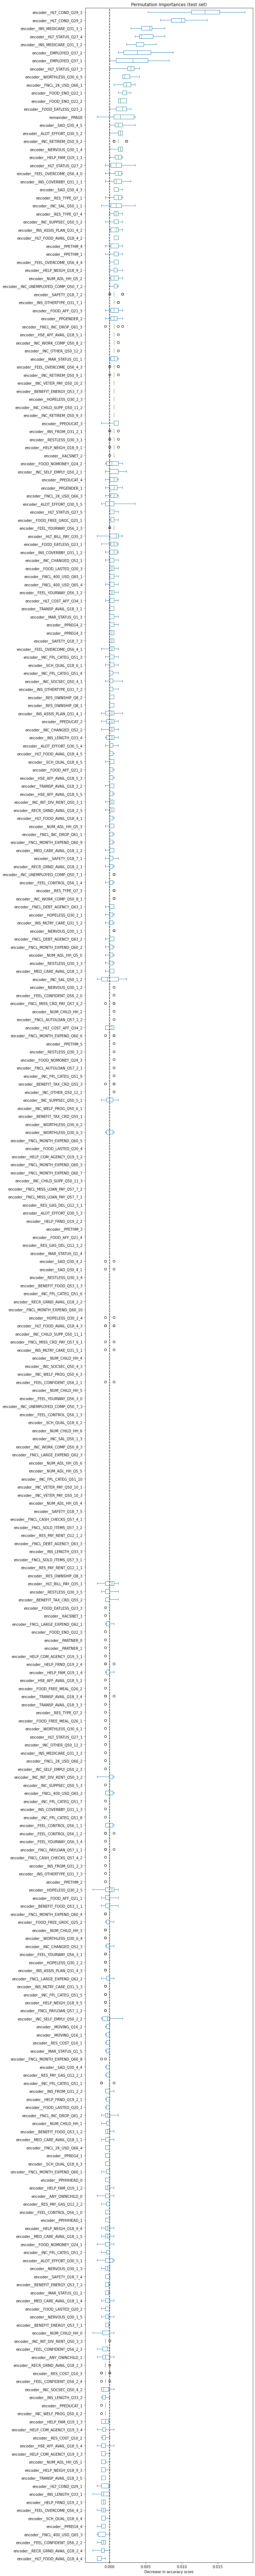

In [26]:
# from sklearn.inspection import permutation_importance

# plt.figure(figsize=(50, 50))
plt.figure(figsize=(5, 50))

# result = permutation_importance(
#     rf_clf_optim2, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()
# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=X_train.columns[sorted_importances_idx],
# )

# importances.to_csv(r'rf_clf_optim2_imp.csv', index=False, header=True)
importances = pd.read_csv('rf_clf_optim2_imp.csv')
importances.head()

ax = importances.plot.box(vert=False, whis=10, figsize=(10, 100))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

<b>Narration:</b> The above permutation importance of rf_clf_optim2 on the training dataset test set shows that a health condition (lasted more than a year) and medicare insurance coverage are the most important feature. Indeed, permuting the values of these features will lead to the most decrease in the accuracy score of the model on the test set. Let's try permuting features with no importance (median ≤ 0 in the x-axis) to check whether the model score decreases on the test set. 

### Using the Important Features

In [28]:
col_new = []
for i in range(0,importances.shape[1]):
    if importances.iloc[:,i].median() <= 0: #a feature with the median ≤ 0 to be excluded from the model
        importances.iloc[:,i].name
        col_new.append(importances.iloc[:,i].name) 
X_enc_df2 = X_enc_df.drop(col_new,axis=1)

In [29]:
#Getting the important features only
enc_columns = X_enc_df2.columns
unenc_columns = X.columns
final_col_names = [] #The final column names for the user to provide
for ii in range(0,len(enc_columns)):
    for jj in range(0,len(unenc_columns)):
        temp_var = enc_columns[ii]
        if temp_var[0:9] == 'encoder__':
            temp_var = temp_var[9:-2]
        else:
            temp_var = temp_var[9:]
        if unenc_columns[jj] in temp_var:
            final_col_names.append(unenc_columns[jj])
final_col_names = set(final_col_names)
print(f"The important features required to run the predictive model are: {final_col_names}")

The important features required to run the predictive model are: {'INS_MEDICARE_Q31_3', 'INS_COVERBBY_Q31_1', 'EMPLOYED_Q37', 'FOOD_ENO_Q22', 'PPREG4', 'HELP_NEIGH_Q18_9', 'FOOD_LASTED_Q20', 'INC_WORK_COMP_Q50_8', 'HLT_BILL_PAY_Q35', 'INS_OTHERTYPE_Q31_7', 'PPAGE', 'MAR_STATUS_Q1', 'INC_CHANGED_Q52', 'FEEL_YOURWAY_Q56_3', 'ALOT_EFFORT_Q30_5', 'HOPELESS_Q30_2', 'WORTHLESS_Q30_6', 'INC_CHILD_SUPP_Q50_11', 'NUM_ADL_HH_Q5', 'PPGENDER', 'HLT_COST_AFF_Q34', 'FNCL_INC_DROP_Q61', 'INS_ASSIS_PLAN_Q31_4', 'FOOD_AFF_Q21', 'FOOD_NOMONEY_Q24', 'FEEL_OVERCOME_Q56_4', 'XACSNET', 'TRANSP_AVAIL_Q18_3', 'SAD_Q30_4', 'RESTLESS_Q30_3', 'INC_UNEMPLOYED_COMP_Q50_7', 'RECR_GRND_AVAIL_Q18_2', 'NERVOUS_Q30_1', 'RES_TYPE_Q7', 'INC_INT_DIV_RENT_Q50_3', 'INS_FROM_Q31_2', 'HELP_FAM_Q19_1', 'BENEFIT_ENERGY_Q53_7', 'FNCL_2K_USD_Q66', 'FNCL_400_USD_Q65', 'PPEDUCAT', 'FOOD_FREE_GROC_Q25', 'INC_SUPPSEC_Q50_5', 'SAFETY_Q18_7', 'HSE_AFF_AVAIL_Q18_5', 'FOOD_EATLESS_Q23', 'HLT_COND_Q29', 'INC_VETER_PAY_Q50_10', 'INC_SAL_Q5

Testing using the features mentioned above

In [30]:
df3 = df2.copy()
#change dtypes to categorical variables of some of the variables
int_cols = ['PPAGE']
for cols in df3.columns:
    if cols in int_cols:
        df3[cols] = df3[cols].astype(int)
#         print(df3[cols].dtype,'type')
    else: 
        df3[cols] = df3[cols].astype(object)
#         print(df3[cols].dtype)

#Breaking data into X2 and y
warnings.simplefilter(action='ignore', category=FutureWarning)
final_col_names = sorted(final_col_names)
X2 = df3[final_col_names]
X2 = X2.sort_index(axis=1)
y = df3['HLT_IMPAIR_Q28']
y=y.astype('int') 

In [31]:
#Running OneHotEncoding to the dataset, but before that we need to get the right coloumns for the encoding
coloumns_to_encode = X2.select_dtypes(include = ['object']).columns
#Build a ColumnTransformer to encode the above features in X except Age
one_hot_transformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False),coloumns_to_encode)],\
                                        remainder = "passthrough"
                                       )
X_enc = one_hot_transformer.fit_transform(X2)
#Name the coloumns
X_enc_df = pd.DataFrame(X_enc)
X_enc_df.columns = one_hot_transformer.get_feature_names_out(input_features=X2.columns)
#Splitting the dataset X and y
seed = 100 #for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X_enc_df,y,test_size=0.3, stratify=y, random_state = seed)

In [32]:
rf_clf_optim2 = RandomForestClassifier(n_estimators = 10000,
                                       criterion = 'entropy',
                                       random_state=seed,
                                       max_features='auto')
rf_clf_optim2.fit(X_train, y_train)
y_pred = rf_clf_optim2.predict(X_test)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),1)*100}%",'\n')
print('\x1b[1;30m'+'Classification Report'+'\x1b[0m')
print(classification_report(y_test, y_pred, target_names=['Impairment (1)', 'No Impairment (2)']))

The accuracy of the model is 90.0% 

Classification Report
                   precision    recall  f1-score   support

   Impairment (1)       0.69      0.51      0.59       259
No Impairment (2)       0.92      0.96      0.94      1445

         accuracy                           0.89      1704
        macro avg       0.80      0.74      0.76      1704
     weighted avg       0.88      0.89      0.88      1704



<b>Narration:</b> Using the important features, the above features did not change the model score (90%) or the classification report. Let us use these features and oversampling to see whether our model performs better.

[Return to contents](#Table-of-Contents)

### Using the Important Features and Oversampling

In [33]:
df3 = df2.copy()
#change dtypes to categorical variables of some of the variables
int_cols = ['PPAGE']
#To avoid SMOTE to convert int to floats, I will change every feature to 'int' type
for cols in df3.columns:
    if cols in int_cols:
        df3[cols] = df3[cols].astype(int)
#         print(df3[cols].dtype,'type')
    else: 
        df3[cols] = df3[cols].astype(int)
#         print(df3[cols].dtype)

#Breaking data into X2 and y
X2 = df3[final_col_names]
X2 = X2.sort_index(axis=1)
y = df3['HLT_IMPAIR_Q28']
y=y.astype('int') 
#Oversample
oversample = SMOTE()
X, y = oversample.fit_resample(X2, y)
#And then convert X to object except PPAGE
for cols in X.columns:
    if cols in int_cols:
        X[cols] = X[cols].astype(int)
#         print(X[cols].dtype,'type')
    else: 
        X[cols] = X[cols].astype(object)
#         print(X[cols].dtype)

In [34]:
#Running OneHotEncoding to the dataset, but before that we need to get the right coloumns for the encoding
coloumns_to_encode = X.select_dtypes(include = ['object']).columns
#Build a ColumnTransformer to encode the above features in X except Age
one_hot_transformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False),coloumns_to_encode)],\
                                        remainder = "passthrough"
                                       )
X_enc = one_hot_transformer.fit_transform(X)
#Name the coloumns
X_enc_df = pd.DataFrame(X_enc)
X_enc_df.columns = one_hot_transformer.get_feature_names_out(input_features=X.columns)
#Splitting the dataset X and y
seed = 100 #for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X_enc_df,y,test_size=0.3, stratify=y, random_state = seed)

In [35]:
rf_clf_optim2 = RandomForestClassifier(n_estimators = 10000,
                                       criterion = 'entropy',
                                       random_state=seed,
                                       max_features='auto')
rf_clf_optim2.fit(X_train, y_train)
y_pred = rf_clf_optim2.predict(X_test)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),1)*100}%",'\n')
print('\x1b[1;30m'+'Classification Report'+'\x1b[0m')
print(classification_report(y_test, y_pred, target_names=['Impairment (1)', 'No Impairment (2)']))

The accuracy of the model is 90.0% 

Classification Report
                   precision    recall  f1-score   support

   Impairment (1)       0.92      0.94      0.93      1445
No Impairment (2)       0.94      0.92      0.93      1444

         accuracy                           0.93      2889
        macro avg       0.93      0.93      0.93      2889
     weighted avg       0.93      0.93      0.93      2889



<b>Narration:</b> The model yielded an accuracy of 90% using the important features and oversampling. The precision for both classes was high (>90%), suggesting that the model had high accuracy in labeling whether participants were impaired. The recall score was also high, indicating that the model correctly captured a higher fraction of individuals belonging to either of the classes (impaired or not). Finally, the model yielded a high f1-score for both classes (>90%), i.e., the predictions from the model were >90% accurate. We will build out the final model using only the important features and predict user-provided data using the improved model.

[Return to contents](#Table-of-Contents)

# Final Model

A user can provide new data to predict whether an individual or group of individuals have any impairments. The following are the columns required for the model to predict the outcome.

### User Input: New Data

A user can complete the questions below to complete the questionnaire. The responses will be saved in a dataframe and parsed by the model to predict the presence of health impairment.

In [36]:
#Qn 1
print('Qn: Are you now?',\
      '1: Married',
      '2: Widowed',
      '3: Divorced',
      '4: Separated',
      '5: Never married',sep='\n')
MAR_STATUS_Q1 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='MAR_STATUS_Q1',
    disabled=False,
)
display(MAR_STATUS_Q1)

#Qn 2
print('Qn: Number of adults 19 and older other than self in household',\
      '0: 0',
      '1: 1',
      '2: 2',
      '3: 3',
      '4: 4',
      '5: 5',
      '6: 6 or more',sep='\n')
NUM_ADL_HH_Q5 = widgets.Dropdown(
    options=np.linspace(0, 6, 7, dtype=int),
    description='NUM_ADL_HH_Q5',
    disabled=False,
)
display(NUM_ADL_HH_Q5)


# Qn 3
print('Qn: Which of the following best describes the place where you live?',\
      '1: A one-family house detached from any other house',
      '2: A one-family house attached to one or more houses',
      '3: A building with 2 or more apartments',
      '4: A mobile home, boat, RV, van, or something else', sep='\n')
RES_TYPE_Q7 = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='RES_TYPE_Q7',
    disabled=False,
)
display(RES_TYPE_Q7)

#Qn 4
print('Qn: How would you rate the availability of parks and playgrounds of your neighborhood?',\
      '1: Excellent',
      '2: Very good',
      '3: Good',
      '4: Fair',
      '5: Poor',sep='\n')
RECR_GRND_AVAIL_Q18_2 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='RECR_GRND_AVAIL_Q18_2',
    disabled=False,
)
display(RECR_GRND_AVAIL_Q18_2)

#Qn 5
print('Qn: How would you rate the access to public transportation of your neighborhood?',\
      '1: Excellent',
      '2: Very good',
      '3: Good',
      '4: Fair',
      '5: Poor',sep='\n')
TRANSP_AVAIL_Q18_3 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='TRANSP_AVAIL_Q18_3',
    disabled=False,
)
display(TRANSP_AVAIL_Q18_3)

# Qn 6
print('Qn: How would you rate the availability of places to buy healthy food of your neighborhood?',\
      '1: Excellent',
      '2: Very good',
      '3: Good',
      '4: Fair',
      '5: Poor',sep='\n')
HLT_FOOD_AVAIL_Q18_4 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='HLT_FOOD_AVAIL_Q18_4',
    disabled=False,
)
display(HLT_FOOD_AVAIL_Q18_4)

# Qn 7
print('Qn: How would you rate the availability of affordable housing of your neighborhood?',\
      '1: Excellent',
      '2: Very good',
      '3: Good',
      '4: Fair',
      '5: Poor',sep='\n')
HSE_AFF_AVAIL_Q18_5 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='HSE_AFF_AVAIL_Q18_5',
    disabled=False,
)
display(HSE_AFF_AVAIL_Q18_5)

#Qn 8
print('Qn: How would you rate the safety from crime and violence of your neighborhood?',\
      '1: Excellent',
      '2: Very good',
      '3: Good',
      '4: Fair',
      '5: Poor',sep='\n')
SAFETY_Q18_7 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='SAFETY_Q18_7',
    disabled=False,
)
display(SAFETY_Q18_7)

#Qn 9
print('Qn: How would you rate the your neighborhood as a place where neighbors help each other?',\
      '1: Excellent',
      '2: Very good',
      '3: Good',
      '4: Fair',
      '5: Poor',sep='\n')
HELP_NEIGH_Q18_9 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='HELP_NEIGH_Q18_9',
    disabled=False,
)
display(HELP_NEIGH_Q18_9)

# Qn 10
print('Qn: If you had a problem with which you needed help (for example, sickness or moving), how much help would you expect to get from family',\
      '1: All of the help needed',
      '2: Most of the help needed',
      '3: Very little of the help needed',
      '4: No help', sep='\n')
HELP_FAM_Q19_1 = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='HELP_FAM_Q19_1',
    disabled=False,
)
display(HELP_FAM_Q19_1)

#Qn 11
print('Qn: The food that I or we bought just didn’t last, and I or we didn’t have money to get more. Was that often, sometimes, or never true for you or your household in the last 12 months?',\
      '1: Often true',
      '2: Sometimes true',
      '3: Never true',
      '4: Don''t know',sep='\n')
FOOD_LASTED_Q20 = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='FOOD_LASTED_Q20',
    disabled=False,
)
display(FOOD_LASTED_Q20)

#Qn 12
print('Qn: I or we couldn’t afford to eat balanced meals. Was that often, sometimes, or never true for you or your household in the last 12 months?',\
      '1: Often true',
      '2: Sometimes true',
      '3: Never true',
      '4: Don''t know',sep='\n')
FOOD_AFF_Q21 = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='FOOD_AFF_Q21',
    disabled=False,
)
display(FOOD_AFF_Q21)

# Qn 13
print('Qn: In the last 12 months, since last current month, did you or other adults in your household\
 ever cut the size of your meals or skip meals because there wasn''t enough money for food?',\
      '1: Yes',
      '2: No',
      '3: Dont know', sep='\n')
FOOD_ENO_Q22 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='FOOD_ENO_Q22',
    disabled=False,
)
display(FOOD_ENO_Q22)

#Qn 14
print('Qn: In the last 12 months, did you ever eat less than you felt you should because there wasn''t enough money for food?',\
      '1: Yes',
      '2: No',
      '3: Don''t Know',sep='\n')
FOOD_EATLESS_Q23 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='FOOD_EATLESS_Q23',
    disabled=False,
)
display(FOOD_EATLESS_Q23)

#Qn 15
print('Qn: In the last 12 months, were you ever hungry but didn''t eat because there wasn''t enough money for food?',\
      '1: Yes',
      '2: No',
      '3: Don''t Know',sep='\n')
FOOD_NOMONEY_Q24 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='FOOD_NOMONEY_Q24',
    disabled=False,
)
display(FOOD_NOMONEY_Q24)

# Qn 16
print('Qn: During the past 30 days, have you or anyone in your household gotten free groceries\
 from a food pantry, food bank, church, or other place that helps with free food?',\
      '1: Yes',
      '2: No', sep='\n')
FOOD_FREE_GROC_Q25 = widgets.Dropdown(
    options=np.linspace(1, 2, 2, dtype=int),
    description='FOOD_FREE_GROC_Q25',
    disabled=False,
)
display(FOOD_FREE_GROC_Q25)

# Qn 17
print('Qn: In general, would you say your health is...',\
      '1: Excellent',
      '2: Very good',
      '3: Good',
      '4: Fair',
      '5: Poor',sep='\n')
HLT_STATUS_Q27 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='HLT_STATUS_Q27',
    disabled=False,
)
display(HLT_STATUS_Q27)

# Qn 18
print('Qn: Do you currently have a health condition that has lasted for a year or more or is expected to last for a year or more?',\
      '1: Yes, one condition',
      '2: Yes, more than one condition',
      '3: No', sep='\n')
HLT_COND_Q29 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='HLT_COND_Q29',
    disabled=False,
)
display(HLT_COND_Q29)

# Qn 19
print('Qn: During the past 30 days, about how often did you feel nervous?',\
      '1: All of the time',
      '2: Most of the time',
      '3: Some of the time', 
      '4: A little of the time',\
      '5: None of the time',sep='\n')
NERVOUS_Q30_1 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='NERVOUS_Q30_1',
    disabled=False,
)
display(NERVOUS_Q30_1)

#Qn 20
print('Qn: During the past 30 days, about how often did you feel hopeless?',\
      '1: All of the time',
      '2: Most of the time',
      '3: Some of the time',
      '4: A little of the time',
      '5: None',sep='\n')
HOPELESS_Q30_2 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='HOPELESS_Q30_2',
    disabled=False,
)
display(HOPELESS_Q30_2)

#Qn 21
print('Qn: During the past 30 days, about how often did you feel restless or fidgety?',\
      '1: All of the time',
      '2: Most of the time',
      '3: Some of the time', 
      '4: A little of the time',\
      '5: None of the time',sep='\n')
RESTLESS_Q30_3 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='RESTLESS_Q30_3',
    disabled=False,
)
display(RESTLESS_Q30_3)

#Qn 22
print('Qn: During the past 30 days, about how often did you feel so sad that nothing could cheer you up?',\
      '1: All of the time',
      '2: Most of the time',
      '3: Some of the time', 
      '4: A little of the time',\
      '5: None of the time',sep='\n')
SAD_Q30_4 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='SAD_Q30_4',
    disabled=False,
)
display(SAD_Q30_4)

#Qn 23
print('Qn: During the past 30 days, about how often did you feel that everything was an effort?',\
      '1: All of the time',
      '2: Most of the time',
      '3: Some of the time', 
      '4: A little of the time',\
      '5: None of the time',sep='\n')
ALOT_EFFORT_Q30_5 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='ALOT_EFFORT_Q30_5',
    disabled=False,
)
display(ALOT_EFFORT_Q30_5)

#Qn 24
print('Qn: During the past 30 days, about how often did you feel worthless?',\
      '1: All of the time',
      '2: Most of the time',
      '3: Some of the time', 
      '4: A little of the time',\
      '5: None of the time',sep='\n')
WORTHLESS_Q30_6 = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='WORTHLESS_Q30_6',
    disabled=False,
)
display(WORTHLESS_Q30_6) 

# Qn 25
print('Qn: Are you currently covered by insurance through a current or former employer or union?',\
      '1: Covered',
      '2: Not covered',
      '3: Not sure', sep='\n')
INS_COVERBBY_Q31_1 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INS_COVERBBY_Q31_1',
    disabled=False,
)
display(INS_COVERBBY_Q31_1)

# Qn 26
print('Qn: Are you currently covered by insurance purchased directly from an insurance company?',\
      '1: Covered',
      '2: Not covered',
      '3: Not sure', sep='\n')
INS_FROM_Q31_2 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INS_FROM_Q31_2',
    disabled=False,
)
display(INS_FROM_Q31_2)

#Qn 27
print('Qn: Are you currently covered by Medicare?',\
      '1: Covered',
      '2: Not covered',
      '3: Not sure', sep='\n')
INS_MEDICARE_Q31_3 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INS_MEDICARE_Q31_3',
    disabled=False,
)
display(INS_MEDICARE_Q31_3)

# Qn 28
print('Qn: Are you currently covered by Medicaid, Medical Assistance (MA), the Children''s Health\
 Insurance Program (CHIP) or any kind of state or government-sponsored assistance plan\
 based on income or a disability?', 
      '1: Covered',
      '2: Not covered',
      '3: Not sure', sep='\n')
INS_ASSIS_PLAN_Q31_4 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INS_ASSIS_PLAN_Q31_4',
    disabled=False,
)
display(INS_ASSIS_PLAN_Q31_4)

# Qn 29
print('Qn: Are you currently covered by any other type of health insurance coverage or health coverage plan?',\
      '1: Covered',
      '2: Not covered',
      '3: Not sure', sep='\n')
INS_OTHERTYPE_Q31_7 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INS_OTHERTYPE_Q31_7',
    disabled=False,
)
display(INS_OTHERTYPE_Q31_7)

#Qn 30
print('Qn: Thinking about your health insurance coverage over the past 12 months, how many months were you insured since (current month) and (current year-1)?',\
      '1: I was insured all 12 months',
      '2: I was insured 6 to 11 months',
      '3: I was insured 1 to 5 months',
      '4: I did not have health insurance at all over the past 12 months', sep='\n')
INS_LENGTH_Q33 = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='INS_LENGTH_Q33',
    disabled=False,
)
display(INS_LENGTH_Q33)

#Qn 31
print('Qn: Thinking about your health care experiences over the past 12 months, that is, since (current month)\
 and (current year-1), was there any time when you needed medical care but\
 did not get it because you couldn''t afford it?',\
      '1: Yes',
      '2: No',sep='\n')
HLT_COST_AFF_Q34 = widgets.Dropdown(
    options=np.linspace(1, 2, 2, dtype=int),
    description='HLT_COST_AFF_Q34',
    disabled=False,
)
display(HLT_COST_AFF_Q34)

#Qn 32
print('Qn: In the past 12 months, did you or anyone in your family have problems paying or were unable to pay any medical bills?',\
      '1: Yes',
      '2: No',sep='\n')
HLT_BILL_PAY_Q35 = widgets.Dropdown(
    options=np.linspace(1, 2, 2, dtype=int),
    description='HLT_BILL_PAY_Q35',
    disabled=False,
)
display(HLT_BILL_PAY_Q35)

#Qn 33
print('Qn: Are you currently working for pay or self-employed?',\
      '1: Yes, working for pay or self-employed',
      '2: No, not working',sep='\n')
EMPLOYED_Q37 = widgets.Dropdown(
    options=np.linspace(1, 2, 2, dtype=int),
    description='EMPLOYED_Q37',
    disabled=False,
)
display(EMPLOYED_Q37)

#Qn 34
print('Qn: In the last 12 months, have you and your family received wages or salaries?',\
      '1: Yes',
      '2: No',
      '3: Dont know',sep='\n')
INC_SAL_Q50_1 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_SAL_Q50_1',
    disabled=False,
)
display(INC_SAL_Q50_1)

#Qn 35
print('Qn: In the last 12 months, have you and your family received interest, dividends, or rental income?',\
      '1: Yes',
      '2: No',
      '3: Dont know', sep='\n')
INC_INT_DIV_RENT_Q50_3 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_INT_DIV_RENT_Q50_3',
    disabled=False,
)
display(INC_INT_DIV_RENT_Q50_3)

# Qn 36
print('Qn: In the last 12 months, have you and your family received supplemental security sncome (SSI)?',\
      '1: Yes',
      '2: No',
      '3: Dont know', sep='\n')
INC_SUPPSEC_Q50_5 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_SUPPSEC_Q50_5',
    disabled=False,
)
display(INC_SUPPSEC_Q50_5)

#Qn 37
print('Qn: In the last 12 months, have you and your family received unemployment compensation?',\
      '1: Yes',
      '2: No',
      '3: Dont know',sep='\n')
INC_UNEMPLOYED_COMP_Q50_7 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_UNEMPLOYED_COMP_Q50_7',
    disabled=False,
)
display(INC_UNEMPLOYED_COMP_Q50_7)

#Qn 38
print('Qn: In the last 12 months, have you and your family received workers'' compensation?',\
      '1: Yes',
      '2: No',
      '3: Don''t Know',sep='\n')
INC_WORK_COMP_Q50_8 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_WORK_COMP_Q50_8',
    disabled=False,
)
display(INC_WORK_COMP_Q50_8)

#Qn 39
print('Qn: "In the last 12 months, have you and your family received pension, annuity, or retirement account income?',\
      '1: Yes',
      '2: No',
      '3: Dont know', sep='\n')
INC_RETIREM_Q50_9 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_RETIREM_Q50_9',
    disabled=False,
)
display(INC_RETIREM_Q50_9) 

# Qn 40
print('Qn: In the last 12 months, have you and your family received veterans'' (VA) payments?',\
      '1: Yes',
      '2: No',
      '3: Dont know',sep='\n')
INC_VETER_PAY_Q50_10 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_VETER_PAY_Q50_10',
    disabled=False,
)
display(INC_VETER_PAY_Q50_10)

#Qn 41
print('Qn: In the last 12 months, have you and your family received child support or alimony?',\
      '1: Yes',
      '2: No',
      '3: Don''t Know',sep='\n')
INC_CHILD_SUPP_Q50_11 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_CHILD_SUPP_Q50_11',
    disabled=False,
)
display(INC_CHILD_SUPP_Q50_11)

# Qn 42
print('Qn: In the last 12 months, have you and your family received any other income?',\
      '1: Yes',
      '2: No',
      '3: Dont know', sep='\n')
INC_OTHER_Q50_12 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_OTHER_Q50_12',
    disabled=False,
)
display(INC_OTHER_Q50_12) 

#Qn 43
print('Qn: In the past 12 months, which of the following best describes how your family''s \
income changed from month to month, if at all?',
      '1: Roughly the same each month',
      '2: Roughly the same most months, but some unusually high or low months during the year',
      '3: Often varies quite a bit from one month to the next',sep='\n')
INC_CHANGED_Q52 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='INC_CHANGED_Q52',
    disabled=False,
)
display(INC_CHANGED_Q52)

#Qn 44
print('Qn: Did you or anyone in your family receive The Low Income Home Energy Assistance Program (LIHEAP) at any time since (current month) (-1)?',\
      '1: Yes',
      '2: No',
      '3: Dont know',sep='\n')
BENEFIT_ENERGY_Q53_7 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='BENEFIT_ENERGY_Q53_7',
    disabled=False,
)
display(BENEFIT_ENERGY_Q53_7)

#Qn 45
print('Qn: In the last month, how often have you felt that things were going your way?',\
      '0: Never', 
      '1: Almost never',
      '2: Sometimes',
      '3: Fairly often',
      '4: Very often', sep='\n')
FEEL_YOURWAY_Q56_3 = widgets.Dropdown(
    options=np.linspace(0, 4, 5, dtype=int),
    description='FEEL_YOURWAY_Q56_3',
    disabled=False,
)
display(FEEL_YOURWAY_Q56_3)

#Qn 46
print('Qn: In the last month, how often have you felt difficulties were piling up so high that you could not overcome them?',\
      '0: Never', 
      '1: Almost never',
      '2: Sometimes',
      '3: Fairly often',
      '4: Very often', sep='\n')
FEEL_OVERCOME_Q56_4 = widgets.Dropdown(
    options=np.linspace(0, 4, 5, dtype=int),
    description='FEEL_OVERCOME_Q56_4',
    disabled=False,
)
display(FEEL_OVERCOME_Q56_4)

#Qn 47
print('Qn: In the past 12 months, have you and your family experienced a large drop in income which you did not expect?',\
      '1: Yes',
      '2: No',
      '3: Dont know', sep='\n')
FNCL_INC_DROP_Q61 = widgets.Dropdown(
    options=np.linspace(1, 3, 3, dtype=int),
    description='FNCL_INC_DROP_Q61',
    disabled=False,
)
display(FNCL_INC_DROP_Q61)

# Qn 48
print('Qn: How confident are you that you could come up with $400 if an unexpected expense arose within the next month?', 
      '1: Not at all confident',
      '2: Not too confident',
      '3: Somewhat confident',
      '4: Very confident',sep='\n')
FNCL_400_USD_Q65 = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='FNCL_400_USD_Q65',
    disabled=False,
)
display(FNCL_400_USD_Q65)

#Qn 49
print('Qn: How confident are you that you could come up with $2,000 if an unexpected expense arose within the next monthy?',\
      '1: Not at all confident',
      '2: Not too confident',
      '3: Somewhat confident',
      '4: Very confident',sep='\n')
FNCL_2K_USD_Q66 = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='FNCL_2K_USD_Q66',
    disabled=False,
)
display(FNCL_2K_USD_Q66)

#Qn 50
print('Qn: What is the age of the participant in years?',sep='\n')
PPAGE = widgets.Dropdown(
    options=np.linspace(18, 64, 47,dtype=int),
    description='PPAGE',
    disabled=False,
)
display(PPAGE)

#Qn 51
print('Qn: Education (categorical)',\
      '1: Less than high school',
      '2: High school',
      '3: Some college',
      '4: Bachelor''s degree or higher',sep='\n')
PPEDUCAT = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='PPEDUCAT',
    disabled=False,
)
display(PPEDUCAT)

#Qn 52
print('Qn: Race/Ethnicity',\
      '1: White, Non-Hispanic',
      '2: Black, Non-Hispanic',
      '3: Other, Non-Hispanic',
      '4: Hispanic',
      '5: 2+ Races, Non-Hispanic',sep='\n')
PPETHM = widgets.Dropdown(
    options=np.linspace(1, 5, 5, dtype=int),
    description='PPETHM',
    disabled=False,
)
display(PPETHM)

# Qn 53
print('Qn: Gender',\
      '1: Male',
      '2: Female', sep='\n')
PPGENDER = widgets.Dropdown(
    options=np.linspace(1, 2, 2, dtype=int),
    description='PPGENDER',
    disabled=False,
)
display(PPGENDER)

# Qn 54
print('Qn: Region 4 - based on state of residence', 
      '1: Northeast',
      '2: Midwest',
      '3: South',
      '4: West',sep='\n')
PPREG4 = widgets.Dropdown(
    options=np.linspace(1, 4, 4, dtype=int),
    description='PPREG4',
    disabled=False,
)
display(PPREG4)

# Qn 55
print('Qn: ACS Internet access',\
      '1: Yes',
      '2: No',sep='\n')
XACSNET = widgets.Dropdown(
    options=np.linspace(1, 2, 2, dtype=int),
    description='XACSNET',
    disabled=False,
)
display(XACSNET)



Qn: Are you now?
1: Married
2: Widowed
3: Divorced
4: Separated
5: Never married


Dropdown(description='MAR_STATUS_Q1', options=(1, 2, 3, 4, 5), value=1)

Qn: Number of adults 19 and older other than self in household
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6 or more


Dropdown(description='NUM_ADL_HH_Q5', options=(0, 1, 2, 3, 4, 5, 6), value=0)

Qn: Which of the following best describes the place where you live?
1: A one-family house detached from any other house
2: A one-family house attached to one or more houses
3: A building with 2 or more apartments
4: A mobile home, boat, RV, van, or something else


Dropdown(description='RES_TYPE_Q7', options=(1, 2, 3, 4), value=1)

Qn: How would you rate the availability of parks and playgrounds of your neighborhood?
1: Excellent
2: Very good
3: Good
4: Fair
5: Poor


Dropdown(description='RECR_GRND_AVAIL_Q18_2', options=(1, 2, 3, 4, 5), value=1)

Qn: How would you rate the access to public transportation of your neighborhood?
1: Excellent
2: Very good
3: Good
4: Fair
5: Poor


Dropdown(description='TRANSP_AVAIL_Q18_3', options=(1, 2, 3, 4, 5), value=1)

Qn: How would you rate the availability of places to buy healthy food of your neighborhood?
1: Excellent
2: Very good
3: Good
4: Fair
5: Poor


Dropdown(description='HLT_FOOD_AVAIL_Q18_4', options=(1, 2, 3, 4, 5), value=1)

Qn: How would you rate the availability of affordable housing of your neighborhood?
1: Excellent
2: Very good
3: Good
4: Fair
5: Poor


Dropdown(description='HSE_AFF_AVAIL_Q18_5', options=(1, 2, 3, 4, 5), value=1)

Qn: How would you rate the safety from crime and violence of your neighborhood?
1: Excellent
2: Very good
3: Good
4: Fair
5: Poor


Dropdown(description='SAFETY_Q18_7', options=(1, 2, 3, 4, 5), value=1)

Qn: How would you rate the your neighborhood as a place where neighbors help each other?
1: Excellent
2: Very good
3: Good
4: Fair
5: Poor


Dropdown(description='HELP_NEIGH_Q18_9', options=(1, 2, 3, 4, 5), value=1)

Qn: If you had a problem with which you needed help (for example, sickness or moving), how much help would you expect to get from family
1: All of the help needed
2: Most of the help needed
3: Very little of the help needed
4: No help


Dropdown(description='HELP_FAM_Q19_1', options=(1, 2, 3, 4), value=1)

Qn: The food that I or we bought just didn’t last, and I or we didn’t have money to get more. Was that often, sometimes, or never true for you or your household in the last 12 months?
1: Often true
2: Sometimes true
3: Never true
4: Dont know


Dropdown(description='FOOD_LASTED_Q20', options=(1, 2, 3, 4), value=1)

Qn: I or we couldn’t afford to eat balanced meals. Was that often, sometimes, or never true for you or your household in the last 12 months?
1: Often true
2: Sometimes true
3: Never true
4: Dont know


Dropdown(description='FOOD_AFF_Q21', options=(1, 2, 3, 4), value=1)

Qn: In the last 12 months, since last current month, did you or other adults in your household ever cut the size of your meals or skip meals because there wasnt enough money for food?
1: Yes
2: No
3: Dont know


Dropdown(description='FOOD_ENO_Q22', options=(1, 2, 3), value=1)

Qn: In the last 12 months, did you ever eat less than you felt you should because there wasnt enough money for food?
1: Yes
2: No
3: Dont Know


Dropdown(description='FOOD_EATLESS_Q23', options=(1, 2, 3), value=1)

Qn: In the last 12 months, were you ever hungry but didnt eat because there wasnt enough money for food?
1: Yes
2: No
3: Dont Know


Dropdown(description='FOOD_NOMONEY_Q24', options=(1, 2, 3), value=1)

Qn: During the past 30 days, have you or anyone in your household gotten free groceries from a food pantry, food bank, church, or other place that helps with free food?
1: Yes
2: No


Dropdown(description='FOOD_FREE_GROC_Q25', options=(1, 2), value=1)

Qn: In general, would you say your health is...
1: Excellent
2: Very good
3: Good
4: Fair
5: Poor


Dropdown(description='HLT_STATUS_Q27', options=(1, 2, 3, 4, 5), value=1)

Qn: Do you currently have a health condition that has lasted for a year or more or is expected to last for a year or more?
1: Yes, one condition
2: Yes, more than one condition
3: No


Dropdown(description='HLT_COND_Q29', options=(1, 2, 3), value=1)

Qn: During the past 30 days, about how often did you feel nervous?
1: All of the time
2: Most of the time
3: Some of the time
4: A little of the time
5: None of the time


Dropdown(description='NERVOUS_Q30_1', options=(1, 2, 3, 4, 5), value=1)

Qn: During the past 30 days, about how often did you feel hopeless?
1: All of the time
2: Most of the time
3: Some of the time
4: A little of the time
5: None


Dropdown(description='HOPELESS_Q30_2', options=(1, 2, 3, 4, 5), value=1)

Qn: During the past 30 days, about how often did you feel restless or fidgety?
1: All of the time
2: Most of the time
3: Some of the time
4: A little of the time
5: None of the time


Dropdown(description='RESTLESS_Q30_3', options=(1, 2, 3, 4, 5), value=1)

Qn: During the past 30 days, about how often did you feel so sad that nothing could cheer you up?
1: All of the time
2: Most of the time
3: Some of the time
4: A little of the time
5: None of the time


Dropdown(description='SAD_Q30_4', options=(1, 2, 3, 4, 5), value=1)

Qn: During the past 30 days, about how often did you feel that everything was an effort?
1: All of the time
2: Most of the time
3: Some of the time
4: A little of the time
5: None of the time


Dropdown(description='ALOT_EFFORT_Q30_5', options=(1, 2, 3, 4, 5), value=1)

Qn: During the past 30 days, about how often did you feel worthless?
1: All of the time
2: Most of the time
3: Some of the time
4: A little of the time
5: None of the time


Dropdown(description='WORTHLESS_Q30_6', options=(1, 2, 3, 4, 5), value=1)

Qn: Are you currently covered by insurance through a current or former employer or union?
1: Covered
2: Not covered
3: Not sure


Dropdown(description='INS_COVERBBY_Q31_1', options=(1, 2, 3), value=1)

Qn: Are you currently covered by insurance purchased directly from an insurance company?
1: Covered
2: Not covered
3: Not sure


Dropdown(description='INS_FROM_Q31_2', options=(1, 2, 3), value=1)

Qn: Are you currently covered by Medicare?
1: Covered
2: Not covered
3: Not sure


Dropdown(description='INS_MEDICARE_Q31_3', options=(1, 2, 3), value=1)

Qn: Are you currently covered by Medicaid, Medical Assistance (MA), the Childrens Health Insurance Program (CHIP) or any kind of state or government-sponsored assistance plan based on income or a disability?
1: Covered
2: Not covered
3: Not sure


Dropdown(description='INS_ASSIS_PLAN_Q31_4', options=(1, 2, 3), value=1)

Qn: Are you currently covered by any other type of health insurance coverage or health coverage plan?
1: Covered
2: Not covered
3: Not sure


Dropdown(description='INS_OTHERTYPE_Q31_7', options=(1, 2, 3), value=1)

Qn: Thinking about your health insurance coverage over the past 12 months, how many months were you insured since (current month) and (current year-1)?
1: I was insured all 12 months
2: I was insured 6 to 11 months
3: I was insured 1 to 5 months
4: I did not have health insurance at all over the past 12 months


Dropdown(description='INS_LENGTH_Q33', options=(1, 2, 3, 4), value=1)

Qn: Thinking about your health care experiences over the past 12 months, that is, since (current month) and (current year-1), was there any time when you needed medical care but did not get it because you couldnt afford it?
1: Yes
2: No


Dropdown(description='HLT_COST_AFF_Q34', options=(1, 2), value=1)

Qn: In the past 12 months, did you or anyone in your family have problems paying or were unable to pay any medical bills?
1: Yes
2: No


Dropdown(description='HLT_BILL_PAY_Q35', options=(1, 2), value=1)

Qn: Are you currently working for pay or self-employed?
1: Yes, working for pay or self-employed
2: No, not working


Dropdown(description='EMPLOYED_Q37', options=(1, 2), value=1)

Qn: In the last 12 months, have you and your family received wages or salaries?
1: Yes
2: No
3: Dont know


Dropdown(description='INC_SAL_Q50_1', options=(1, 2, 3), value=1)

Qn: In the last 12 months, have you and your family received interest, dividends, or rental income?
1: Yes
2: No
3: Dont know


Dropdown(description='INC_INT_DIV_RENT_Q50_3', options=(1, 2, 3), value=1)

Qn: In the last 12 months, have you and your family received supplemental security sncome (SSI)?
1: Yes
2: No
3: Dont know


Dropdown(description='INC_SUPPSEC_Q50_5', options=(1, 2, 3), value=1)

Qn: In the last 12 months, have you and your family received unemployment compensation?
1: Yes
2: No
3: Dont know


Dropdown(description='INC_UNEMPLOYED_COMP_Q50_7', options=(1, 2, 3), value=1)

Qn: In the last 12 months, have you and your family received workers compensation?
1: Yes
2: No
3: Dont Know


Dropdown(description='INC_WORK_COMP_Q50_8', options=(1, 2, 3), value=1)

Qn: "In the last 12 months, have you and your family received pension, annuity, or retirement account income?
1: Yes
2: No
3: Dont know


Dropdown(description='INC_RETIREM_Q50_9', options=(1, 2, 3), value=1)

Qn: In the last 12 months, have you and your family received veterans (VA) payments?
1: Yes
2: No
3: Dont know


Dropdown(description='INC_VETER_PAY_Q50_10', options=(1, 2, 3), value=1)

Qn: In the last 12 months, have you and your family received child support or alimony?
1: Yes
2: No
3: Dont Know


Dropdown(description='INC_CHILD_SUPP_Q50_11', options=(1, 2, 3), value=1)

Qn: In the last 12 months, have you and your family received any other income?
1: Yes
2: No
3: Dont know


Dropdown(description='INC_OTHER_Q50_12', options=(1, 2, 3), value=1)

Qn: In the past 12 months, which of the following best describes how your familys income changed from month to month, if at all?
1: Roughly the same each month
2: Roughly the same most months, but some unusually high or low months during the year
3: Often varies quite a bit from one month to the next


Dropdown(description='INC_CHANGED_Q52', options=(1, 2, 3), value=1)

Qn: Did you or anyone in your family receive The Low Income Home Energy Assistance Program (LIHEAP) at any time since (current month) (-1)?
1: Yes
2: No
3: Dont know


Dropdown(description='BENEFIT_ENERGY_Q53_7', options=(1, 2, 3), value=1)

Qn: In the last month, how often have you felt that things were going your way?
0: Never
1: Almost never
2: Sometimes
3: Fairly often
4: Very often


Dropdown(description='FEEL_YOURWAY_Q56_3', options=(0, 1, 2, 3, 4), value=0)

Qn: In the last month, how often have you felt difficulties were piling up so high that you could not overcome them?
0: Never
1: Almost never
2: Sometimes
3: Fairly often
4: Very often


Dropdown(description='FEEL_OVERCOME_Q56_4', options=(0, 1, 2, 3, 4), value=0)

Qn: In the past 12 months, have you and your family experienced a large drop in income which you did not expect?
1: Yes
2: No
3: Dont know


Dropdown(description='FNCL_INC_DROP_Q61', options=(1, 2, 3), value=1)

Qn: How confident are you that you could come up with $400 if an unexpected expense arose within the next month?
1: Not at all confident
2: Not too confident
3: Somewhat confident
4: Very confident


Dropdown(description='FNCL_400_USD_Q65', options=(1, 2, 3, 4), value=1)

Qn: How confident are you that you could come up with $2,000 if an unexpected expense arose within the next monthy?
1: Not at all confident
2: Not too confident
3: Somewhat confident
4: Very confident


Dropdown(description='FNCL_2K_USD_Q66', options=(1, 2, 3, 4), value=1)

Qn: What is the age of the participant in years?


Dropdown(description='PPAGE', options=(18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,…

Qn: Education (categorical)
1: Less than high school
2: High school
3: Some college
4: Bachelors degree or higher


Dropdown(description='PPEDUCAT', options=(1, 2, 3, 4), value=1)

Qn: Race/Ethnicity
1: White, Non-Hispanic
2: Black, Non-Hispanic
3: Other, Non-Hispanic
4: Hispanic
5: 2+ Races, Non-Hispanic


Dropdown(description='PPETHM', options=(1, 2, 3, 4, 5), value=1)

Qn: Gender
1: Male
2: Female


Dropdown(description='PPGENDER', options=(1, 2), value=1)

Qn: Region 4 - based on state of residence
1: Northeast
2: Midwest
3: South
4: West


Dropdown(description='PPREG4', options=(1, 2, 3, 4), value=1)

Qn: ACS Internet access
1: Yes
2: No


Dropdown(description='XACSNET', options=(1, 2), value=1)

[Return to contents](#Table-of-Contents)

### Predict Using New Data

In [37]:
#save the input from the user
data_user = {MAR_STATUS_Q1.description : [MAR_STATUS_Q1.value],
             NUM_ADL_HH_Q5.description : [NUM_ADL_HH_Q5.value],
             RES_TYPE_Q7.description : [RES_TYPE_Q7.value],
             RECR_GRND_AVAIL_Q18_2.description : [RECR_GRND_AVAIL_Q18_2.value],
             TRANSP_AVAIL_Q18_3.description : [TRANSP_AVAIL_Q18_3.value],
             HLT_FOOD_AVAIL_Q18_4.description : [HLT_FOOD_AVAIL_Q18_4.value],
             HSE_AFF_AVAIL_Q18_5.description : [HSE_AFF_AVAIL_Q18_5.value],
             SAFETY_Q18_7.description : [SAFETY_Q18_7.value],
             HELP_NEIGH_Q18_9.description : [HELP_NEIGH_Q18_9.value],
             HELP_FAM_Q19_1.description : [HELP_FAM_Q19_1.value],
             FOOD_LASTED_Q20.description : [FOOD_LASTED_Q20.value],
             FOOD_AFF_Q21.description : [FOOD_AFF_Q21.value],
             FOOD_ENO_Q22.description : [FOOD_ENO_Q22.value],
             FOOD_EATLESS_Q23.description : [FOOD_EATLESS_Q23.value],
             FOOD_NOMONEY_Q24.description : [FOOD_NOMONEY_Q24.value],
             FOOD_FREE_GROC_Q25.description : [FOOD_FREE_GROC_Q25.value],
             HLT_STATUS_Q27.description : [HLT_STATUS_Q27.value],
             HLT_COND_Q29.description : [HLT_COND_Q29.value],
             NERVOUS_Q30_1.description : [NERVOUS_Q30_1.value],
             HOPELESS_Q30_2.description : [HOPELESS_Q30_2.value],
             RESTLESS_Q30_3.description : [RESTLESS_Q30_3.value],
             SAD_Q30_4.description : [SAD_Q30_4.value],
             ALOT_EFFORT_Q30_5.description : [ALOT_EFFORT_Q30_5.value],
             WORTHLESS_Q30_6.description : [WORTHLESS_Q30_6.value],
             INS_COVERBBY_Q31_1.description : [INS_COVERBBY_Q31_1.value],
             INS_FROM_Q31_2.description : [INS_FROM_Q31_2.value],
             INS_MEDICARE_Q31_3.description : [INS_MEDICARE_Q31_3.value],
             INS_ASSIS_PLAN_Q31_4.description : [INS_ASSIS_PLAN_Q31_4.value],
             INS_OTHERTYPE_Q31_7.description : [INS_OTHERTYPE_Q31_7.value],
             INS_LENGTH_Q33.description : [INS_LENGTH_Q33.value],
             HLT_COST_AFF_Q34.description : [HLT_COST_AFF_Q34.value],
             HLT_BILL_PAY_Q35.description : [HLT_BILL_PAY_Q35.value],
             EMPLOYED_Q37.description : [EMPLOYED_Q37.value],
             INC_SAL_Q50_1.description : [INC_SAL_Q50_1.value],
             INC_INT_DIV_RENT_Q50_3.description : [INC_INT_DIV_RENT_Q50_3.value],
             INC_SUPPSEC_Q50_5.description : [INC_SUPPSEC_Q50_5.value],
             INC_UNEMPLOYED_COMP_Q50_7.description : [INC_UNEMPLOYED_COMP_Q50_7.value],
             INC_WORK_COMP_Q50_8.description : [INC_WORK_COMP_Q50_8.value],
             INC_RETIREM_Q50_9.description : [INC_RETIREM_Q50_9.value],
             INC_VETER_PAY_Q50_10.description : [INC_VETER_PAY_Q50_10.value],
             INC_CHILD_SUPP_Q50_11.description : [INC_CHILD_SUPP_Q50_11.value],
             INC_OTHER_Q50_12.description : [INC_OTHER_Q50_12.value], 
             INC_CHANGED_Q52.description : [INC_CHANGED_Q52.value],
             BENEFIT_ENERGY_Q53_7.description : [BENEFIT_ENERGY_Q53_7.value],
             FEEL_YOURWAY_Q56_3.description : [FEEL_YOURWAY_Q56_3.value],
             FEEL_OVERCOME_Q56_4.description : [FEEL_OVERCOME_Q56_4.value],
             FNCL_INC_DROP_Q61.description : [FNCL_INC_DROP_Q61.value],
             FNCL_400_USD_Q65.description : [FNCL_400_USD_Q65.value],
             FNCL_2K_USD_Q66.description : [FNCL_2K_USD_Q66.value],
             PPAGE.description : [PPAGE.value],
             PPEDUCAT.description : [PPEDUCAT.value],
             PPETHM.description : [PPETHM.value],
             PPGENDER.description : [PPGENDER.value],
             PPREG4.description : [PPREG4.value],
             XACSNET.description : [XACSNET.value]
            }
#Build a dataframe
df_user = pd.DataFrame(data_user)
df_user = df_user.sort_index(axis=1)

#change dtypes to categorical variables of some of the variables
int_cols = ['PPAGE']
for cols in df_user.columns:
    if cols in int_cols:
        df_user[cols] = df_user[cols].astype(int)
#         print(df_user[cols].dtype,'type')
    else: 
        df_user[cols] = df_user[cols].astype(object)
#         print(df_user[cols].dtype)

#Encoding
warnings.simplefilter(action='ignore', category=FutureWarning)
# Transforming the dataset by OneHotEncoding. We will trnsform using the above X_train transformation
X_user_enc = one_hot_transformer.transform(df_user)
#Name the coloumns
X_user_enc_df = pd.DataFrame(X_user_enc)
X_user_enc_df.columns = one_hot_transformer.get_feature_names_out(input_features=df_user.columns)

#Predicting the outcome
y_pred_user = rf_clf_optim2.predict(X_user_enc_df)
# print(y_pred_user[0])
#Report
if y_pred_user == 1:
    str_outcome = "The participant might have a physical or mental condition, impairment, or disability"
else:
    str_outcome = "The participant might not have a health impairment or condition"
print('\x1b[1;31m'+'Prediction:'+'\x1b[0m',str_outcome)

Prediction: The participant might have a physical or mental condition, impairment, or disability


[Return to contents](#Table-of-Contents)

# Conclusion

Using different determinants of health (Health insurance, Housing, Food security, Employment, Family income, and Family financial security), I can predict with a high degree of accuracy whether an individual – a representative of a US resident - has a physical or mental condition, impairment, or disability. This predictive algorithm is applicable to:

1. Federal, State, and Local governments can derive policies that can help address a health condition. For example, provide devices to help perform daily activities (for example, walking); subsidize insurance premiums to afford quality medical care; and provide lifestyle coaching services, such as weight loss training, stress management, and a balanced diet.

2. Health agencies, such as the National Institutes of Health (NIH) and Centers for Disease Control and Prevention (CDC), can determine existing health conditions (e.g., diabetes, heart disease, etc.) and the necessity for interventions (medications).

### Recommendation

The predictive model requires a higher number of questions responded (features) to predict health impairment. A participant may not answer every question in the survey above (user input). Therefore, further model optimization is needed to reduce the number of features for prediction without a loss in accuracy.

[Return to contents](#Table-of-Contents)